In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Wed_Jun__2_19:15:15_PDT_2021
Cuda compilation tools, release 11.4, V11.4.48
Build cuda_11.4.r11.4/compiler.30033411_0
gcc (Ubuntu 9.3.0-17ubuntu1~20.04) 9.3.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [4]:
# install dependencies: (use cu111 because colab has CUDA 11.1)
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -v -e .



Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html
Cloning into 'mmdetection'...
remote: Enumerating objects: 32638, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 32638 (delta 57), reused 88 (delta 14), pack-reused 32466
Receiving objects: 100% (32638/32638), 43.27 MiB | 22.11 MiB/s, done.
Resolving deltas: 100% (23037/23037), done.
/aiffel/mmdetection/mmdetection
Using pip 21.3.1 from /opt/conda/lib/python3.9/site-packages/pip (python 3.9)
Obtaining file:///aiffel/mmdetection/mmdetection
  Running command python setup.py egg_info
  running egg_info
  creating /tmp/pip-pip-egg-info-pdp2thl9/mmdet.egg-info
  writing /tmp/pip-pip-egg-info-pdp2thl9/mmdet.egg-info/PKG-INFO
  writing dependency_links to /tmp/pip-pip-egg-info-pdp2thl9/mmdet.egg-info/dependency_links.txt
  writing requirements to /tmp/pip-pip-egg-info

In [5]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.9.0+cu111 True
2.26.0
11.1
GCC 7.3


/opt/conda/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [7]:
# We download the pre-trained checkpoints for inference and finetuning.
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmdetection/v2.0/yolo/yolov3_d53_mstrain-608_273e_coco/yolov3_d53_mstrain-608_273e_coco_20210518_115020-a2c3acb8.pth \
      -O checkpoints/yolov3_d53_mstrain-608_273e_coco_20210518_115020-a2c3acb8.pth

--2022-11-29 07:00:51--  https://download.openmmlab.com/mmdetection/v2.0/yolo/yolov3_d53_mstrain-608_273e_coco/yolov3_d53_mstrain-608_273e_coco_20210518_115020-a2c3acb8.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.86
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248093138 (237M) [application/octet-stream]
Saving to: ‘checkpoints/yolov3_d53_mstrain-608_273e_coco_20210518_115020-a2c3acb8.pth’

checkpoints/yolov3_ 100%[===================>] 236.60M  10.7MB/s    in 23s     

2022-11-29 07:01:16 (10.2 MB/s) - ‘checkpoints/yolov3_d53_mstrain-608_273e_coco_20210518_115020-a2c3acb8.pth’ saved [248093138/248093138]



In [8]:
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

# Choose to use a config and initialize the detector
config = 'configs/yolo/yolov3_d53_mstrain-608_273e_coco.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoints/yolov3_d53_mstrain-608_273e_coco_20210518_115020-a2c3acb8.pth'

# Set the device to be used for evaluation
device='cuda:0'

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint, map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint['meta']['CLASSES']

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()

load checkpoint from local path: checkpoints/yolov3_d53_mstrain-608_273e_coco_20210518_115020-a2c3acb8.pth


YOLOV3(
  (backbone): Darknet(
    (conv1): ConvModule(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activate): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (conv_res_block1): Sequential(
      (conv): ConvModule(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activate): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (res0): ResBlock(
        (conv1): ConvModule(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activate): LeakyReLU(negative_slope=0.1, inplace=True)
        )
        (conv2): ConvModule(
          (conv): Conv2d(32, 64, kerne

In [11]:
# Use the detector to do inference
import os

HOME_DIR = os.getenv('HOME')
img = mmcv.imread(HOME_DIR+'/aiffel/aimmo/image/1659964852731_FR-View-CMR-Wide.jpg')
result = inference_detector(model, img)

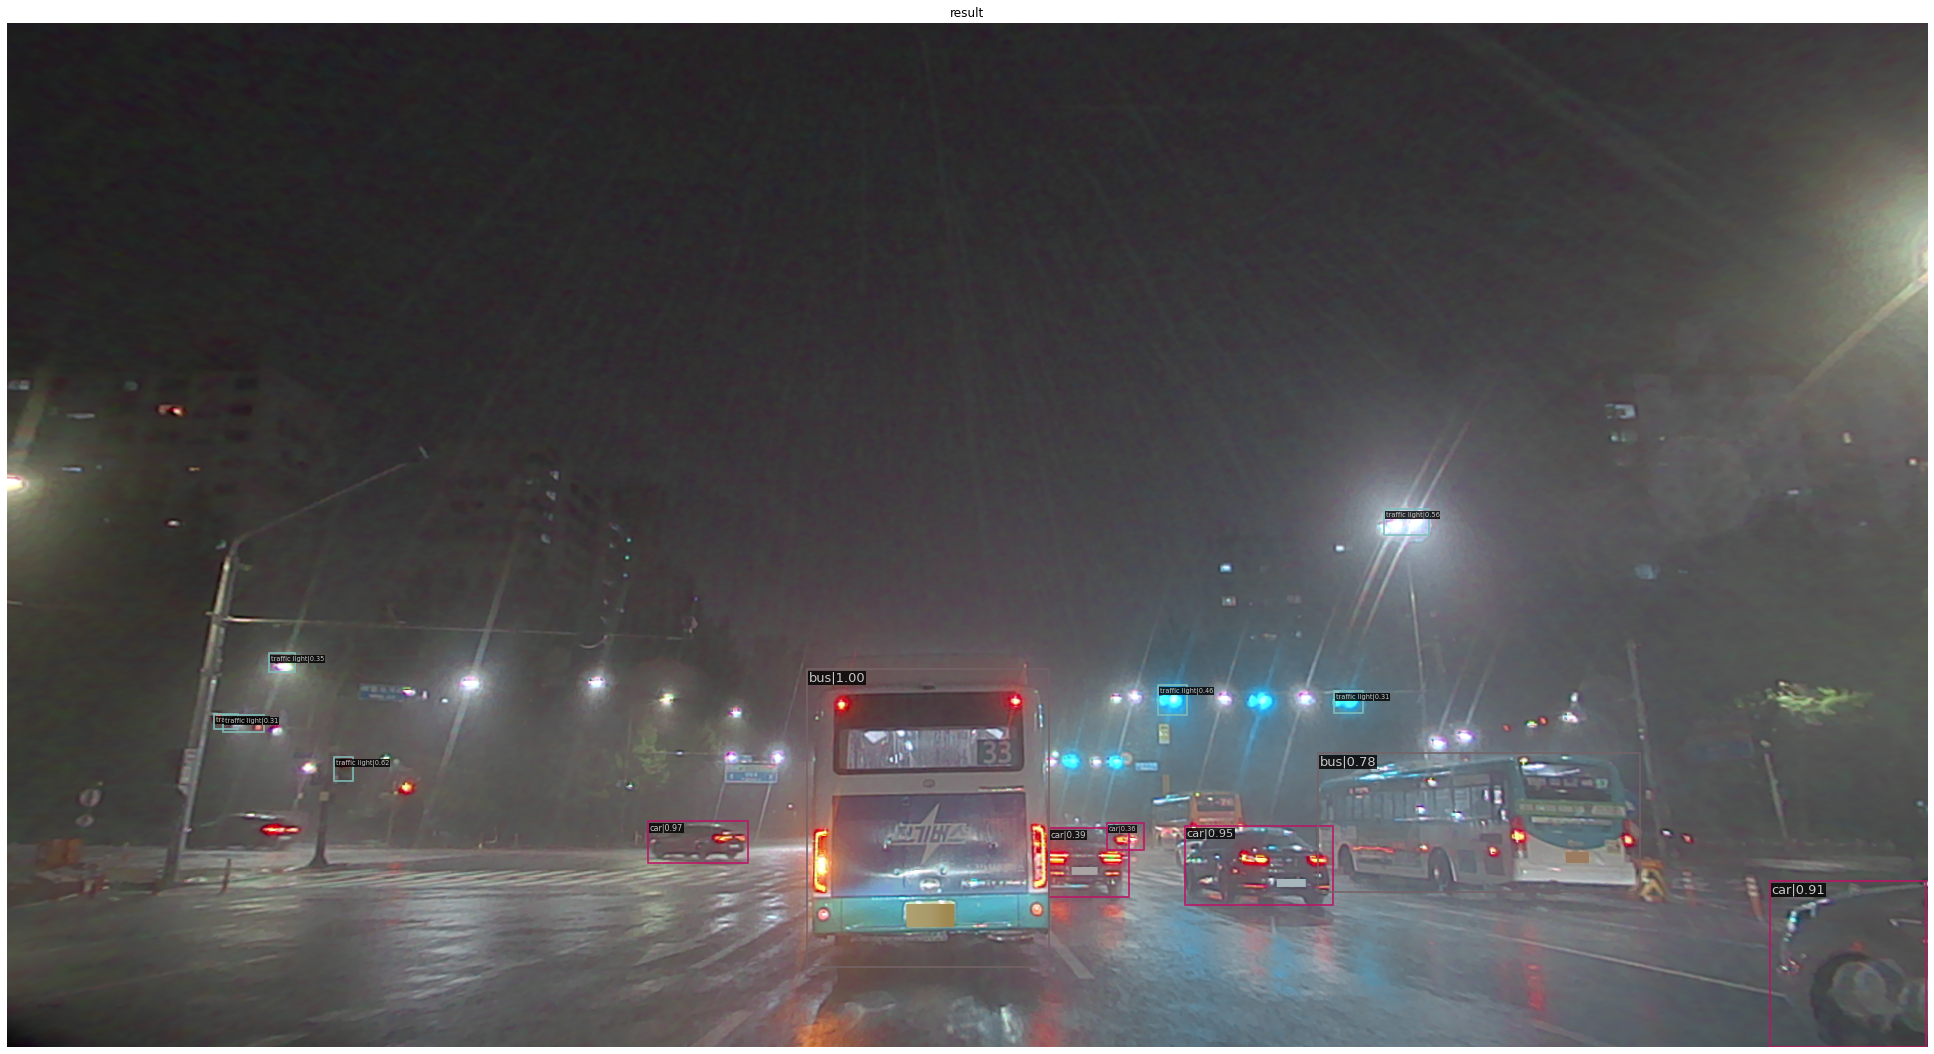

In [13]:
show_result_pyplot(model, img, result, score_thr=0.3)

In [15]:
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.coco import CocoDataset  

@DATASETS.register_module(force=True)
class Aimmo(CocoDataset):
    CLASSES = ('car', 'bus', 'truck', 'pedestrian')

In [16]:
from mmcv import Config
cfg = Config.fromfile('./configs/yolo/yolov3_d53_mstrain-608_273e_coco.py')

In [25]:
from mmdet.apis import init_detector
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
import os.path as osp

from mmdet.apis import set_random_seed
cfg.dataset_type = 'Aimmo'
cfg.data_root = HOME_DIR+'/aiffel/Aimmo_dataset/'

# mg = mmcv.imread(HOME_DIR+'/aiffel/aimmo/image/1659964852731_FR-View-CMR-Wide.jpg')
cfg.data.train.type = 'Aimmo'
cfg.data.train.data_root = HOME_DIR+'/aiffel/Aimmo_dataset/'
cfg.data.train.ann_file = 'Aimmo_datasetCOCO_format_train.json'
cfg.data.train.img_prefix = 'train_image/'

cfg.data.val.type = 'Aimmo'
cfg.data.val.data_root = HOME_DIR+'/aiffel/Aimmo_dataset/'
cfg.data.val.ann_file = 'Aimmo_datasetCOCO_format_val.json'
cfg.data.val.img_prefix = 'val_image/'

cfg.data.test.type = 'Aimmo'
cfg.data.test.data_root = HOME_DIR+'/aiffel/Aimmo_dataset/'
cfg.data.test.ann_file = 'Aimmo_datasetCOCO_format_val.json'
cfg.data.test.img_prefix = 'val_image/'


# modify num classes of the model in box head
cfg.model.bbox_head.num_classes = 4
# If we need to finetune a model based on a pre-trained detector, we need to
# use load_from to set the path of checkpoints.
cfg.load_from = 'checkpoints/yolov3_d53_mstrain-608_273e_coco_20210518_115020-a2c3acb8.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
# cfg.optimizer.lr = 0.00125
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'bbox'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 1
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 10

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# # We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]

cfg.data.samples_per_gpu = 6
cfg.data.workers_per_gpu = 1
cfg['device'] = 'cuda'

cfg.runner['max_epochs'] = 2


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
checkpoint_config = dict(interval=10)
log_config = dict(
    interval=10,
    hooks=[dict(type='TextLoggerHook'),
           dict(type='TensorboardLoggerHook')])
custom_hooks = [dict(type='NumClassCheckHook')]
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = 'checkpoints/yolov3_d53_mstrain-608_273e_coco_20210518_115020-a2c3acb8.pth'
resume_from = None
workflow = [('train', 1)]
opencv_num_threads = 0
mp_start_method = 'fork'
auto_scale_lr = dict(enable=False, base_batch_size=64)
model = dict(
    type='YOLOV3',
    backbone=dict(
        type='Darknet',
        depth=53,
        out_indices=(3, 4, 5),
        init_cfg=dict(type='Pretrained', checkpoint='open-mmlab://darknet53')),
    neck=dict(
        type='YOLOV3Neck',
        num_scales=3,
        in_channels=[1024, 512, 256],
        out_channels=[512, 256, 128]),
    bbox_head=dict(
        type='YOLOV3Head',
        num_classes=4,
        in_channels=[512, 256, 128],
        out_channels=[1024, 512, 256],


In [26]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

loading annotations into memory...
Done (t=1.17s)
creating index...
index created!


2022-11-29 07:19:42,079 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-11-29 07:19:42,263 - mmdet - INFO - load checkpoint from local path: checkpoints/yolov3_d53_mstrain-608_273e_coco_20210518_115020-a2c3acb8.pth


loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


2022-11-29 07:19:42,491 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.convs_pred.0.weight: copying a param with shape torch.Size([255, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([27, 1024, 1, 1]).
size mismatch for bbox_head.convs_pred.0.bias: copying a param with shape torch.Size([255]) from checkpoint, the shape in current model is torch.Size([27]).
size mismatch for bbox_head.convs_pred.1.weight: copying a param with shape torch.Size([255, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([27, 512, 1, 1]).
size mismatch for bbox_head.convs_pred.1.bias: copying a param with shape torch.Size([255]) from checkpoint, the shape in current model is torch.Size([27]).
size mismatch for bbox_head.convs_pred.2.weight: copying a param with shape torch.Size([255, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([27, 256, 1, 1]).
size mismatch for bbox_head.convs_pred.2.bi

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2334/2334, 12.8 task/s, elapsed: 183s, ETA:     0s

2022-11-29 08:14:21,650 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.53s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=16.97s).
Accumulating evaluation results...


2022-11-29 08:14:43,973 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.274
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.629
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.200
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.237
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.400
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.404
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.404
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.404
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.166
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.381
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=3.94s).


2022-11-29 08:14:55,914 - mmdet - INFO - Epoch [2][10/3483]	lr: 1.000e-03, eta: 0:51:12, time: 1.174, data_time: 0.561, memory: 5872, loss_cls: 22.7187, loss_conf: 87.0241, loss_xy: 103.8472, loss_wh: 8.3959, loss: 221.9859, grad_norm: 654.1858
2022-11-29 08:15:05,113 - mmdet - INFO - Epoch [2][20/3483]	lr: 1.000e-03, eta: 0:51:04, time: 0.920, data_time: 0.357, memory: 5872, loss_cls: 22.0851, loss_conf: 82.1441, loss_xy: 98.6106, loss_wh: 7.5609, loss: 210.4008, grad_norm: 665.5559
2022-11-29 08:15:14,464 - mmdet - INFO - Epoch [2][30/3483]	lr: 1.000e-03, eta: 0:50:56, time: 0.935, data_time: 0.346, memory: 5872, loss_cls: 32.2352, loss_conf: 96.3376, loss_xy: 108.4384, loss_wh: 10.3821, loss: 247.3933, grad_norm: 669.7714
2022-11-29 08:15:23,734 - mmdet - INFO - Epoch [2][40/3483]	lr: 1.000e-03, eta: 0:50:47, time: 0.927, data_time: 0.316, memory: 5872, loss_cls: 19.6669, loss_conf: 83.9006, loss_xy: 101.0508, loss_wh: 7.5408, loss: 212.1591, grad_norm: 587.8710
2022-11-29 08:15:32,

FileNotFoundError: [Errno 2] No such file or directory: '/aiffel/mmdetection/mmdetection/tutorial_exps/None.log.json'